In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
accepted = [0, 1]
idx = [i for i, ele in enumerate(y_train) if ele in accepted]
x_train = x_train[idx]
y_train = y_train[idx]

In [4]:
x_train_re = x_train.reshape((x_train.shape[0], -1)) #flattens the list

In [5]:
x_train_re.shape

(12665, 784)

In [6]:
PCA_model = PCA(2)

In [7]:
fitted_PCA = PCA_model.fit(x_train_re).transform(x_train_re)

x = np.array([x[0] for x in fitted_PCA])
y = np.array([x[1] for x in fitted_PCA])

## Downsample

In [8]:
x = x[:100]
y = y[:100]
y_train = y_train[:100]

In [9]:
df = pd.DataFrame({"x": x,
                  "y": y,
                  "label": y_train})

<AxesSubplot:xlabel='x', ylabel='y'>

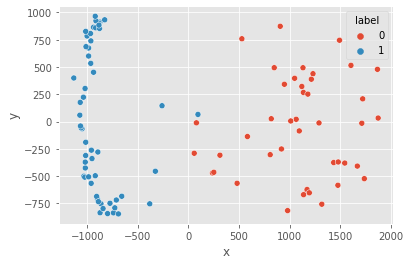

In [10]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "label")

In [11]:
from ipywidgets import widgets

In [12]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

origin = widgets.Dropdown(
    options=list(df['label'].unique()),
    value=0,
    description="class",
)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * len(x)
scatter.marker.color = colors
scatter.marker.size = [10] * len(x)
f.layout.hovermode = 'closest'

values = np.empty(len(x))

# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        if origin.value == 0:
            c[i] = '#963484'
            s[i] = 20
            values[i] = origin.value
        else:
            c[i] = '#3066BE'
            s[i] = 20
            values[i] = origin.value
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s

def response(change):
    return change

scatter.on_click(update_point)
origin.observe(response, names = "value")

widgets.VBox([origin, f])

#f

    'data': [{'marker': …

In [16]:
np.where(values == 1)

(array([56, 59], dtype=int64),)

# Let's make stupid work
First step in this stupid plan: make all the images we need.

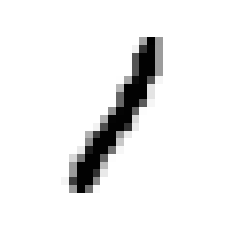

In [14]:
for i in range(100):
    plt.imshow(x_train[i], cmap = "Greys");
    plt.axis("off")
    plt.savefig(f"images/plot{i}")

Second part of the plan; can we actually use the images?

In [17]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.models import Circle
from bokeh.models.widgets import Button
from bokeh.layouts import layout

def save_selected(dataframe, selection):
    '''
    Long term, this should be a function that could execute,
    to make the user save the selection of points they made 
    in the interactive bokeh plot. Does not currently work. That is,
    the save button currently does not map to anything in particular.
    '''
    data = dataframe.iloc[selection]
    def save():
        print(f'I got your df right here! {data.shape}')
        pass # ??? Provide csv to user
    return save

output_file("toolbar.html") #bokeh works in html. Here we just tell bokeh that we want the plot to be called "toolbar.html"

source = ColumnDataSource(data=dict( #the data is given as a dictionary
    x=x,
    y=y,
    desc=["Image" for i in range(len(x))], #adds a description to the different hover options
    imgs=[f"images/plot{i}.png" for i in range(len(x))], #insert the pictures for each hover
    fonts=[
        '<i>What images this?</i>' for i in range(len(x))#, can be removed, but I am afraid of going too deep in html. This just displays a message in the hover
        #'<pre>pre</pre>',
        #'<b>bold</b>',
        #'<small>small</small>',
        #'<del>del</del>'
    ]
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="100" alt="@imgs" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@desc</span>
            <span style="font-size: 15px; color: #966;">[$index]</span>
        </div>
        <div>
            <span>@fonts{safe}</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;">($x, $y)</span>
        </div>
    </div>
""" #html code for displaying on hover. Touch only if you are a daredevil

p = figure(plot_width=1200, plot_height=800, tooltips=TOOLTIPS,
           title="PCA classification", tools = "tap, box_select, lasso_select") #specify how big the plot is, the title, the hover option, and which tools are allowed

renderer = p.circle('x', 'y', size=20, source=source) #specify the renderer for the figure (the dots)

selected_circle = Circle(fill_alpha=1, fill_color="firebrick", line_color=None) #specify a mode for the circles when selected
nonselected_circle = Circle(fill_alpha=0.2, fill_color="blue", line_color="firebrick") #--//-- when unselected

renderer.selection_glyph = selected_circle #tell the renderer what happens to selected
renderer.nonselection_glyph = nonselected_circle # --//-- to unselected

p.toolbar.autohide = True #make the toolbar go away when the mouse is not moving

some_button = Button(label = "Save my selection") #include button for potential save selection
#some_button.on_click()
page = layout([[some_button], [p]]) #specify layout of the page with button first and then the plot

show(page) #display the page